https://pytorch.org/vision/master/auto_examples/plot_scripted_tensor_transforms.html

In [ ]:
# sphinx_gallery_thumbnail_path = "../../gallery/assets/transforms_thumbnail.png"

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'

In [ ]:
orig_img_1 = Image.open(Path('assets') / 'car_photoshopeado.jpeg')

In [ ]:
orig_img_2 = Image.open(Path('assets') / 'interior_car.jpg')

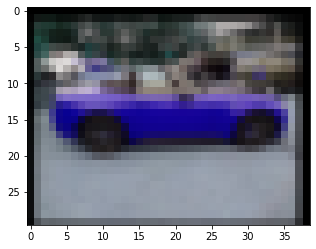

In [ ]:
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)
# 30 is the square resize
transform = T.Resize(30)
resized_img = transform(orig_img_1)
plt.imshow(resized_img)

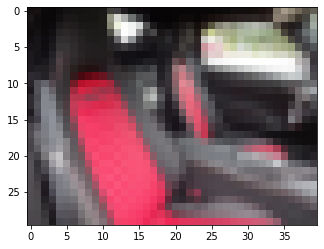

In [ ]:
resized_img = transform(orig_img_2)
plt.imshow(resized_img)

In [ ]:
orig_img_1 = orig_img_1.save("/content/assets/car_1.jpg")
orig_img_2 = orig_img_2.save("/content/assets/car_2.jpg")

## TENSOR TRANSFORMS AND JIT

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

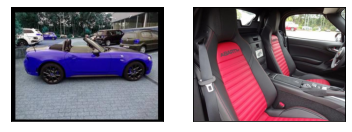

In [ ]:
car1 = read_image(str(Path('assets') / 'car_1.jpg'))
car2 = read_image(str(Path('assets') / 'car_2.jpg'))
show([car1, car2])

## Transforming images on GPU

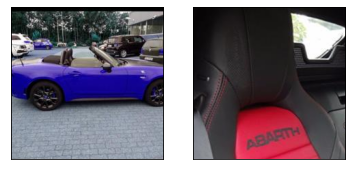

In [ ]:
import torch.nn as nn

transforms = torch.nn.Sequential(
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
car1 = car1.to(device)
car2 = car2.to(device)

transformed_car1 = transforms(car1)
transformed_car2 = transforms(car2)
show([transformed_car1, transformed_car2])

## Scriptable transforms for easier deployment via torchscript

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

In [ ]:
predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([transformed_car1, transformed_car2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

In [ ]:
import json

with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Prediction for Dog 1: ['n03100240', 'convertible']
Prediction for Dog 2: ['n04162706', 'seat_belt']


In [ ]:
import tempfile

with tempfile.NamedTemporaryFile() as f:
    scripted_predictor.save(f.name)

    dumped_scripted_predictor = torch.jit.load(f.name)
    res_scripted_dumped = dumped_scripted_predictor(batch)
assert (res_scripted_dumped == res_scripted).all()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')